# General Setup

In [522]:
import geopandas as gpd
import pandas as pd
import numpy as np
import datetime as dt
from shapely.geometry import Polygon, LineString, Point
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [442]:
def to_latlongcrs(gpd_file):
    """
    checks if gpd_file is in Geographic 2D CRS: EPSG: 4326.  
    If not, returns converted file
    
    Args: gpd_file (GeoDataFrame)
    Returns: gpd_file (GeoDataFrame in EPSG: 4326)
    """
    print(gpd_file.crs.to_string())
    if gpd_file.crs.to_string()[-4:] != '4326':
        print('file converted.')
        gpd_file.to_crs("EPSG:4326",inplace=True)
    else:
        pass
    return gpd_file

In [443]:
#### Load Shapefile data
## Load bikelanes
data_2017 = gpd.read_file('Bicycle_Routes_2017')
data_2018 = gpd.read_file('Bicycle_Routes_2018')
data_2019 = gpd.read_file('Bicycle_Routes_2019')
data_2020 = gpd.read_file('Bicycle_Routes_2020')
data_2021 = gpd.read_file('Bicycle_Routes_2021')

### Get CRS info
data_2017.crs

## Load NYC Zip code - https://data.cityofnewyork.us/Business/
# Zip-Code-Boundaries/i8iw-xf4u/data?no_mobile=true
zip_codes = gpd.read_file('ZIP_CODE')
boroughs = gpd.read_file('Borough boundaries')


In [476]:
## Replace Boro numbers with names in data files

boro_legend = {
    1.0: 'Manhattan', 
    2.0: 'Bronx', 
    3.0: 'Brooklyn', 
    4.0: 'Queens', 
    5.0: 'Staten Island'}

# Replace
boroughs['boro_code'] = boroughs['boro_code'].replace(boro_legend)


In [444]:
### Convert files to Lat-long
data_2017 = to_latlongcrs(data_2017)
data_2018 = to_latlongcrs(data_2018)
data_2019 = to_latlongcrs(data_2019)
data_2020 = to_latlongcrs(data_2020)
data_2021 = to_latlongcrs(data_2021)
zip_codes = to_latlongcrs(zip_codes)

EPSG:2263
file converted.
EPSG:2263
file converted.
EPSG:4326
PROJCS["NAD83_New_York_Long_Island_ftUS",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40.1666666666667],PARAMETER["central_meridian",-74],PARAMETER["standard_parallel_1",40.6666666666667],PARAMETER["standard_parallel_2",41.0333333333333],PARAMETER["false_easting",984250],PARAMETER["false_northing",0],UNIT["Foot_US",0.304800609601219],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
file converted.
EPSG:4326
EPSG:2263
file converted.


In [445]:
# zip_codes.columns
zip_codes_trimmed = zip_codes[['ZIPCODE', 'PO_NAME','geometry']]
zip_codes_trimmed.drop_duplicates(inplace=True)

/Users/julie/opt/anaconda3/envs/newenv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


## Get Accident Zipcodes based on shapes

In [446]:
from geopandas.tools import sjoin

In [479]:
## Bike Data
bike_data_loc = bike_data[['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
           'LONGITUDE', 'LOCATION', 'NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED', 
            'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2']]
bike_data.dropna()
bike_data.dropna(subset=['LOCATION'], inplace=True)

## Create a GeoDataFrame from the bike data DataFrame
bike_data_gdf = gpd.GeoDataFrame(
    bike_data,
    geometry=gpd.points_from_xy(bike_data['LONGITUDE'], bike_data['LATITUDE'])
)

/Users/julie/opt/anaconda3/envs/newenv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [606]:
## Merge the bike data with the zip-codes
zip_results = sjoin(bike_data_gdf.set_crs('EPSG:4326'), zip_codes, how = 'left')
boro_results = sjoin(bike_data_gdf.set_crs('EPSG:4326'), boroughs, how = 'left')

In [594]:
### Borough populations
boro_pops = {
    'Brooklyn': 4970026,      
    'Manhattan':3123068, 
    'Queens': 4460101,
    'Bronx': 2717758,
    'Staten Island': 912458,
    }

In [800]:
boro_results_trimmed = boro_results[['CRASH DATE', 'boro_name', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED']]
boro_results_trimmed['Total Injuries'] = 1
boro_results_trimmed['Total Fatalities'] = 1

/Users/julie/opt/anaconda3/envs/newenv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [828]:
grouped_by_boro = boro_results_trimmed.groupby('boro_name').agg({'NUMBER OF CYCLIST INJURED':'sum', 'NUMBER OF CYCLIST KILLED':'sum'}).sort_values(by='NUMBER OF CYCLIST INJURED', ascending = False)
# grouped_by_boro = grouped_by_boro.rename({'NUMBER OF CYCLIST INJURED':"Injuries"}, inplace= True) 

In [835]:
grouped_by_boro_norm = grouped_by_boro.copy()
grouped_by_boro_norm['population'] = [4970026, 3123068, 4460101, 2717758,912458]

In [836]:
grouped_by_boro_norm

,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,population
boro_name,,,
Brooklyn,8968,39,4970026
Manhattan,6557,21,3123068
Queens,4437,14,4460101
Bronx,2296,11,2717758
Staten Island,375,2,912458


In [837]:
grouped_by_boro_norm.columns

Index(['NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'population'], dtype='object')

In [838]:
grouped_by_boro_norm = grouped_by_boro_norm.rename(columns={'NUMBER OF CYCLIST INJURED':'Injuries by population', 'NUMBER OF CYCLIST KILLED':'Fatalities by population'})
grouped_by_boro_norm['Injuries by population'] = grouped_by_boro_norm['Injuries by population']/grouped_by_boro_norm['population']




In [839]:
grouped_by_boro_norm.columns

Index(['Injuries by population', 'Fatalities by population', 'population'], dtype='object')

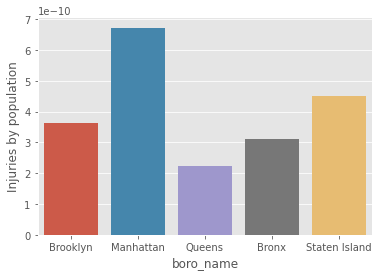

In [840]:
# grouped_by_boro['Population'] = [4970026, 3123068,4460101, 2717758,912458]
# grouped_by_boro = grouped_by_boro[['Injuries by population', 'Fatalities by population']]
# grouped_by_boro
grouped_by_boro_norm = grouped_by_boro_norm.rename(columns={'NUMBER OF CYCLIST INJURED':'Injuries by population', 'NUMBER OF CYCLIST KILLED':'Fatalities by population'})
grouped_by_boro_norm['Injuries by population'] = grouped_by_boro_norm['Injuries by population']/grouped_by_boro_norm['population']
grouped_by_boro_norm['Fatalities by population'] = grouped_by_boro_norm['Fatalities by population']/grouped_by_boro_norm['population']
g = sns.barplot(x="boro_name", y="Injuries by population", data=grouped_by_boro_norm.reset_index())

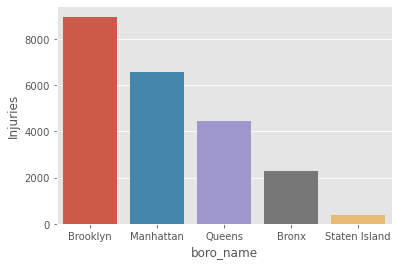

In [841]:
### Not normalized
grouped_by_boro = grouped_by_boro.rename(columns={'NUMBER OF CYCLIST INJURED':'Injuries', 'NUMBER OF CYCLIST KILLED':'Fatalities'})
g = sns.barplot(x="boro_name", y="Injuries", data=grouped_by_boro.reset_index())


ValueError: not enough values to unpack (expected 2, got 0)

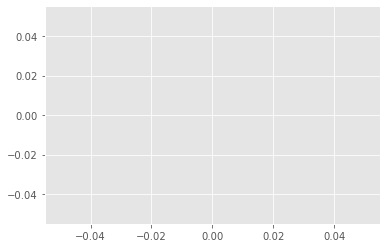

In [868]:

### Not normalized
fig, ax = plt.plot(figsize=(10,10))
# grouped_by_boro = grouped_by_boro.rename(columns={'NUMBER OF CYCLIST INJURED':'Injuries', 'NUMBER OF CYCLIST KILLED':'Fatalities'})
sns.barplot(ax=ax, x="boro_name", y="Injuries", data=grouped_by_boro.reset_index())



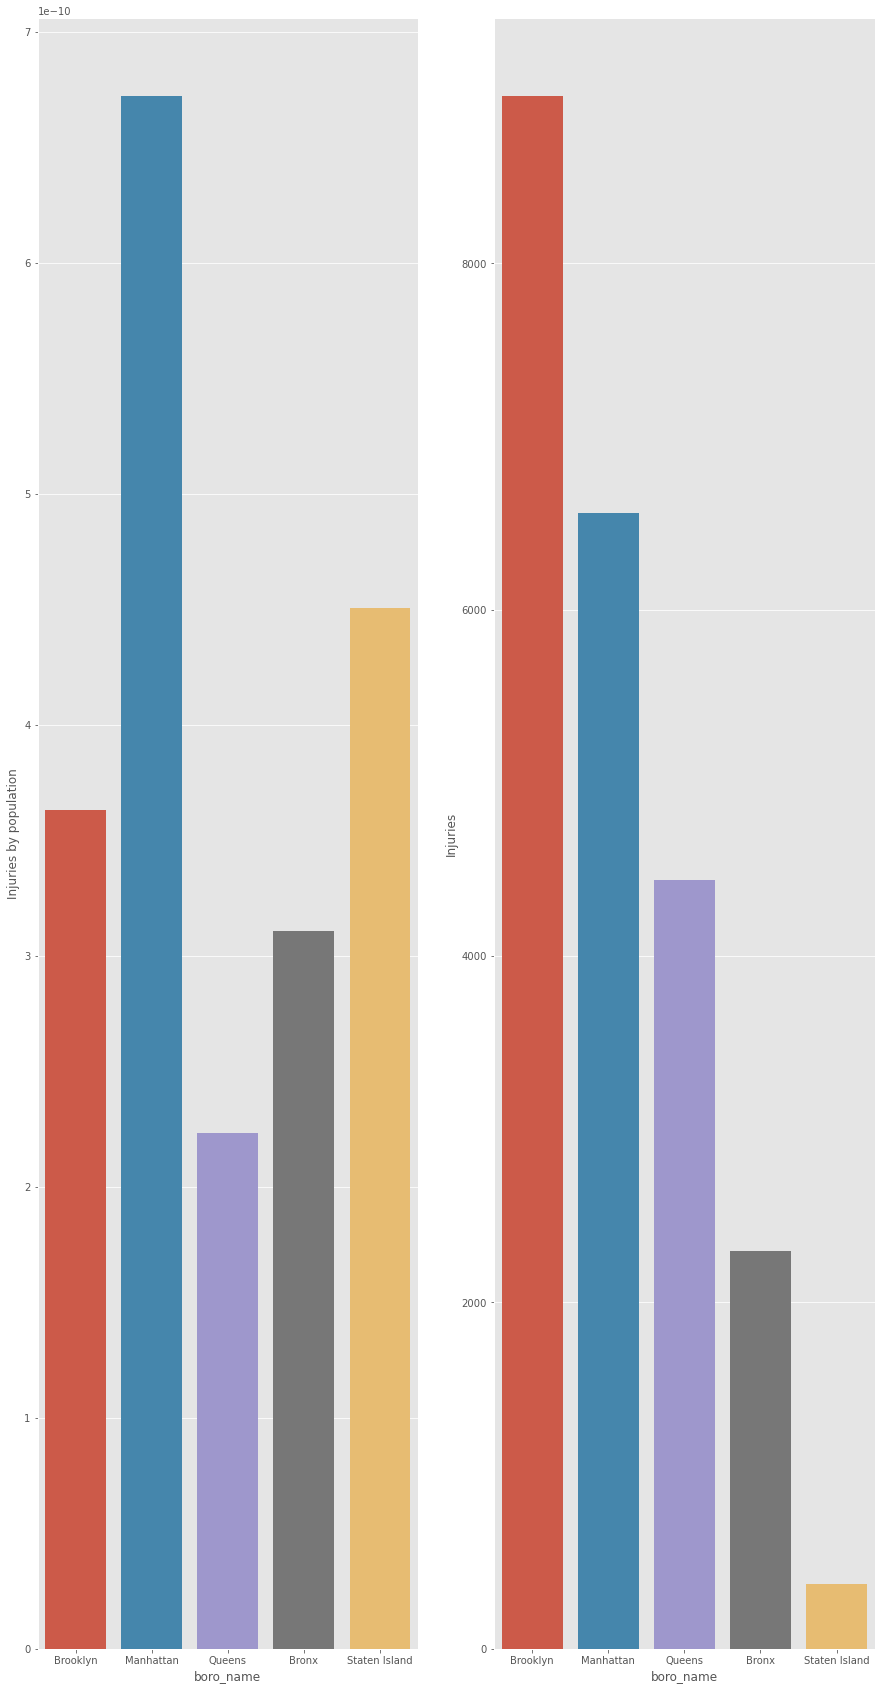

In [869]:
fig,axs = plt.subplots(1,2,figsize=(15,30))
# fig,axs = plt.subplots(1,2,figsize = (45, 30))

g1 = sns.barplot(x="boro_name", y="Injuries by population", data= grouped_by_boro_norm.reset_index(),ax=axs[0])
g2 = sns.barplot(x="boro_name", y="Injuries", data= grouped_by_boro.reset_index(),ax=axs[1])



In [794]:
grouped_by_boro

,Injuries by population,Fatalities by population,population
boro_name,,,
Brooklyn,3.630599e-10,1.578873e-12,4970026
Manhattan,6.722678e-10,2.153061e-12,3123068
Queens,2.230489e-10,7.037828e-13,4460101
Bronx,3.108496e-10,1.489262e-12,2717758
Staten Island,4.504074e-10,2.402173e-12,912458


In [449]:
## Trim the zipcode results
zip_results_trimmed = zip_results[['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'ZIPCODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'PO_NAME',
       'POPULATION', 'AREA']]
bike_data_complete = zip_results_trimmed[['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'ZIPCODE', 'LOCATION',
       'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'PO_NAME',
       'POPULATION', 'AREA']]

### Bike Data Complete - Most dangerous zipcodes

In [717]:
zip_results.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'geometry', 'index_right', 'ZIPCODE', 'BLDGZIP', 'PO_NAME',
       'POPULATION', 'AREA', 'STATE', 'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL',
       'SHAPE_AREA', 'SHAPE_LEN'],
      dtype='object')

In [ ]:
zip_results

In [718]:
zip_ranked = zip_results[['ZIPCODE', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED','POPULATION']]

In [719]:
## looking at the zipcode with population = 0
zip_ranked[zip_ranked['ZIPCODE'] == '10111']

,ZIPCODE,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,POPULATION
103767,10111,1,0,0.0
733083,10111,0,0,0.0
809049,10111,0,0,0.0


In [742]:
# zip_ranked = zip_results[['ZIPCODE', 'CRASH DATE', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', POPULATION]]
zip_ranked = zip_results[['ZIPCODE', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED','POPULATION']]
zip_ranked = zip_ranked.dropna()
zip_ranked['Injuries by pop'] = zip_ranked['NUMBER OF CYCLIST INJURED']/zip_ranked['POPULATION']
zip_ranked['Fatalities by pop'] = zip_ranked['NUMBER OF CYCLIST KILLED']/zip_ranked['POPULATION']
zip_ranked_normalized = zip_ranked[['ZIPCODE', 'Injuries by pop', 'Fatalities by pop']]
zip_ranked_normalized_agg = zip_ranked.groupby('ZIPCODE').agg({'Injuries by pop':'sum', 'Fatalities by pop':'sum'})
zip_ranked_normalized_agg.sort_values(by='Injuries by pop', ascending = False)


,Injuries by pop,Fatalities by pop
ZIPCODE,,
10111,inf,0.000000
00083,5.480000,0.080000
11251,0.229730,0.000000
10018,0.027076,0.000000
10007,0.014885,0.000137
...,...,...
10069,0.000171,0.000000
10044,0.000086,0.000000
10115,0.000000,0.000000


In [775]:
zip_ranked_normalized_agg['ZIPCODE'].isin(trash_list)

0       True
1      False
2      False
3      False
4      False
       ...  
182    False
183    False
184    False
185    False
186    False
Name: ZIPCODE, Length: 187, dtype: bool

## Top 10 Most dangerous zipcodes

In [780]:
## removing non-number values in ranked list
trash_list = ['10111', '10020', '10048', '00083']
zip_ranked_normalized_agg = zip_ranked_normalized_agg[~zip_ranked_normalized_agg['ZIPCODE'].isin(trash_list)]
zip_ranked_normalized_agg = zip_ranked_normalized_agg.sort_values(by='Injuries by pop', ascending = False)
zip_ranked_normalized_agg.head(20)
most_dangerous_zip = zip_ranked_normalized_agg.head(10)
most_dangerous_zip

,ZIPCODE,Injuries by pop,Fatalities by pop
135,11251,0.229730,0.000000
16,10018,0.027076,0.000000
7,10007,0.014885,0.000137
90,11101,0.012798,0.000114
6,10006,0.011292,0.000000
1,10001,0.010619,0.000134
15,10017,0.010366,0.000000
34,10036,0.010109,0.000042
11,10012,0.009474,0.000000
12,10013,0.007969,0.000071


In [788]:
## Most dangerous zips normalized by population 


zip_ranked2 = zip_results[['ZIPCODE', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED']].dropna()
zip_ranked_agg2 = zip_ranked2.groupby('ZIPCODE').agg({'NUMBER OF CYCLIST INJURED':'sum', 'NUMBER OF CYCLIST KILLED':'sum'})
zip_ranked_agg2 = zip_ranked_agg2.sort_values(by='NUMBER OF CYCLIST INJURED', ascending = False)
most_dangerous_zip2 = zip_ranked_agg2.head(10)
most_dangerous_zip2

,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED
ZIPCODE,,
11206,574,2
11211,437,4
10002,423,1
10003,394,2
11368,392,0
11221,388,3
11201,365,0
11226,352,2
11101,336,3


### Most dangerous zipcodes - normalized

In [772]:
zip_ranked_normalized_agg.head(20)

,ZIPCODE,Injuries by pop,Fatalities by pop
0,00083,5.480000,0.080000
1,10001,0.010619,0.000134
2,10002,0.005203,0.000012
3,10003,0.007051,0.000036
4,10004,0.005487,0.000000
5,10005,0.003577,0.000000
6,10006,0.011292,0.000000
7,10007,0.014885,0.000137
8,10009,0.002750,0.000000
9,10010,0.007095,0.000000


In [689]:
zip_ranked = zip_results[['ZIPCODE', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED']]
zip_ranked = zip_ranked.dropna()    
zip_ranked = zip_ranked.rename(columns={'NUMBER OF CYCLIST INJURED':'Injuries', 'NUMBER OF CYCLIST KILLED':'Fatalities'})
zip_ranked = zip_ranked.groupby('ZIPCODE').agg({'Injuries':'sum', 'Fatalities':'sum'})
zip_ranked.sort_values(by='Injuries', ascending=False)

,Injuries,Fatalities
ZIPCODE,,
11206,574,2
11211,437,4
10002,423,1
10003,394,2
11368,392,0
...,...,...
10044,1,0
10069,1,0
10111,1,0


In [655]:
## zipcode and population dictinonary
zip_dict = zip_results[['ZIPCODE', 'POPULATION']]
zip_dict = zip_dict.set_index('ZIPCODE')
# zip_dict = dict(zip_dict)
zip_dict = dict(zip_dict)
zip_dict

{'POPULATION': ZIPCODE
 11368    109069.0
 11214     89061.0
 11205     41125.0
 10452     76104.0
 11201     53041.0
            ...   
 10036     23543.0
 11201     53041.0
 NaN           NaN
 10013     27985.0
 11219     92561.0
 Name: POPULATION, Length: 29501, dtype: float64}

### Injury and Deaths by Borough

In [472]:
bike_data_complete[bike_data_complete['BOROUGH'].isna() == True]

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,ZIPCODE,LOCATION,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,PO_NAME,POPULATION,AREA
91,2021-04-14,0:00,NaN,NaN,11214,"(40.601864, -74.00232)",1,0,Station Wagon/Sport Utility Vehicle,Bike,Brooklyn,89061.0,6.109654e+07
245,2021-04-16,8:30,NaN,NaN,10036,"(40.759163, -73.988396)",1,0,Sedan,Bike,New York,23543.0,1.139511e+07
364,2021-04-15,1:20,NaN,NaN,11106,"(40.76122, -73.93056)",1,0,Bike,NaN,Astoria,38665.0,2.386611e+07
425,2021-04-08,17:25,NaN,NaN,10027,"(40.810173, -73.95117)",1,0,Bike,NaN,New York,58639.0,2.469528e+07
629,2021-04-14,0:27,NaN,NaN,10453,"(40.852673, -73.919106)",1,0,Bike,NaN,Bronx,77576.0,2.574851e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034484,2016-02-26,13:40,NaN,NaN,10014,"(40.729794, -74.002144)",0,0,Station Wagon/Sport Utility Vehicle,Bike,New York,31328.0,1.415105e+07
1042665,2016-03-13,16:30,NaN,NaN,11238,"(40.686996, -73.95685)",1,0,4 dr sedan,Bike,Brooklyn,46664.0,2.942942e+07
1251215,2015-03-19,16:44,NaN,NaN,NaN,"(40.7769, -73.9413)",0,0,Bike,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
1418228,2014-05-17,17:40,NaN,NaN,10472,"(40.830303, -73.8718)",1,0,Sedan,Bike,Bronx,66356.0,3.096325e+07


In [453]:
bike_by_borough = bike_data_complete.groupby('BOROUGH').agg(sum)
bike_by_borough['DENSITY'] = bike_by_borough['POPULATION']/bike_by_borough['AREA']
bike_by_borough
# bike_by_borough['DENSITY'] = bike_data_complete['POPULATION']/bike_data_complete['AREA']

,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,POPULATION,AREA,DENSITY
BOROUGH,,,,,
BRONX,1753,6,136563511.0,8.672281e+10,0.001575
BROOKLYN,6667,29,562861352.0,3.926428e+11,0.001434
MANHATTAN,4706,12,302082262.0,1.116601e+11,0.002705
QUEENS,3414,9,244890379.0,2.223938e+11,0.001101
STATEN ISLAND,231,1,11716742.0,3.383764e+10,0.000346


In [454]:
bike_by_zipcode = bike_data_complete.groupby('ZIPCODE').agg(sum).sort_values('NUMBER OF CYCLIST INJURED',ascending= False)
bike_by_zipcode

,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,POPULATION,AREA
ZIPCODE,,,,
11206,574,2,59003950.0,2.873471e+10
11211,437,4,33412689.0,2.221851e+10
10002,423,1,44555140.0,1.440151e+10
10003,394,2,32688630.0,9.089950e+09
11368,392,0,52244051.0,3.472255e+10
...,...,...,...,...
10044,1,0,11661.0,6.296113e+06
10069,1,0,5850.0,2.372366e+06
10111,1,0,0.0,3.091988e+05


In [846]:
bike_by_zipcode = bike_data_complete.groupby('ZIPCODE').agg(sum).sort_values('NUMBER OF CYCLIST KILLED',ascending= False)
bike_by_zipcode


,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,POPULATION,AREA
ZIPCODE,,,,
11223,220,4,20045864.0,1.473443e+10
11211,437,4,33412689.0,2.221851e+10
11230,237,3,23125102.0,1.427904e+10
11101,336,3,10239060.0,3.079521e+10
11221,388,3,37548576.0,1.805566e+10
...,...,...,...,...
10459,119,0,7020600.0,3.382791e+09
10462,109,0,10215990.0,7.158039e+09
10463,71,0,6357690.0,3.034635e+09


In [870]:
bike_by_zipcode.head(10)

,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,POPULATION,AREA
ZIPCODE,,,,
11223,220,4,20045864.0,1.473443e+10
11211,437,4,33412689.0,2.221851e+10
11230,237,3,23125102.0,1.427904e+10
11101,336,3,10239060.0,3.079521e+10
11221,388,3,37548576.0,1.805566e+10
10001,238,3,8853135.0,7.029002e+09
10023,175,2,16704800.0,4.046582e+09
11374,42,2,2308770.0,1.360992e+09
11229,170,2,15841992.0,1.196375e+10


In [455]:
## Create new column called Accident Count and set all values 1
bike_by_zip_and_time["Accident Count"] = 1
# Create Date column that combines YEAR and MONTH
bike_data_or_trimmed['Date'] = pd.to_datetime(bike_data_or_trimmed[['YEAR', 'MONTH']].assign(Day=1))

## Aggregate by month and year and count accidents
df_  = bike_data_or_trimmed.groupby(['YEAR','MONTH']).agg({"Accident Count":"sum"}).reset_index()
df_['Date'] = pd.to_datetime(df_[['YEAR', 'MONTH']].assign(Day=1))

# Create lineplot
g = sns.lineplot(data=df_, x="Date", y="Accident Count")

bike_data_complete

NameError: name 'bike_by_zip_and_time' is not defined

In [456]:
bike_by_year_zip = bike_data_complete.groupby(['YEAR', 'ZIPCODE']).agg(sum)
bike_by_year_zip

KeyError: 'YEAR'

# Plot Crash Data

In [457]:
## Load crash data
crash_data = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes.csv',
                        parse_dates=['CRASH DATE'])
# Reduce to bikes and e-bikes
bike_data = crash_data[((crash_data['VEHICLE TYPE CODE 1'] == 'Bike')
                       |
                       (crash_data['VEHICLE TYPE CODE 2'] == 'Bike'))] #(31782, 29), bike_data_or

# Trim dataset for locations
sites = bike_data[['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'COLLISION_ID', 'NUMBER OF CYCLIST KILLED']].dropna(subset=['LATITUDE'])

/Users/julie/opt/anaconda3/envs/newenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [458]:
crashes_2017 = sites[sites['CRASH DATE'].dt.year == 2017]
crashes_2018 = sites[sites['CRASH DATE'].dt.year == 2018]
crashes_2019 = sites[sites['CRASH DATE'].dt.year == 2019]
crashes_2020 = sites[sites['CRASH DATE'].dt.year == 2020]
crashes_2021 = sites[sites['CRASH DATE'].dt.year == 2021]

In [459]:
## make points, and a smaller version, delete 0 values
gdf_2017 = gpd.GeoDataFrame(crashes_2017, geometry=gpd.points_from_xy(crashes_2017.LONGITUDE, crashes_2017.LATITUDE))
gdf_2017 = gdf_2017[gdf_2017['LATITUDE'] != 0]

gdf_2018 = gpd.GeoDataFrame(crashes_2018, geometry=gpd.points_from_xy(crashes_2018.LONGITUDE, crashes_2018.LATITUDE))
gdf_2018 = gdf_2018[gdf_2018['LATITUDE'] != 0]

gdf_2019 = gpd.GeoDataFrame(crashes_2019, geometry=gpd.points_from_xy(crashes_2019.LONGITUDE, crashes_2019.LATITUDE))
gdf_2019 = gdf_2019[gdf_2019['LATITUDE'] != 0]

gdf_2020 = gpd.GeoDataFrame(crashes_2020, geometry=gpd.points_from_xy(crashes_2020.LONGITUDE, crashes_2020.LATITUDE))
gdf_2020 = gdf_2020[gdf_2020['LATITUDE'] != 0]

gdf_2021 = gpd.GeoDataFrame(crashes_2021, geometry=gpd.points_from_xy(crashes_2021.LONGITUDE, crashes_2021.LATITUDE))
gdf_2021 = gdf_2021[gdf_2021['LATITUDE'] != 0]

print(gdf_2017.shape)

gdf_2021.dropna(subset=['LOCATION'])
print(gdf_2017.shape)
gdf_2021.head()

(5940, 10)
(5940, 10)


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,COLLISION_ID,NUMBER OF CYCLIST KILLED,geometry
53,2021-04-16,11:00,QUEENS,11368.0,40.749580,-73.865410,"(40.74958, -73.86541)",4407792,0,POINT (-73.86541 40.74958)
91,2021-04-14,0:00,NaN,NaN,40.601864,-74.002320,"(40.601864, -74.00232)",4407649,0,POINT (-74.00232 40.60186)
128,2021-04-14,20:10,BROOKLYN,11238.0,40.688210,-73.965830,"(40.68821, -73.96583)",4407381,0,POINT (-73.96583 40.68821)
140,2021-04-13,17:55,BRONX,10452.0,40.844105,-73.923065,"(40.844105, -73.923065)",4407789,0,POINT (-73.92306 40.84410)
146,2021-04-14,19:45,BROOKLYN,11201.0,40.694840,-73.983910,"(40.69484, -73.98391)",4407414,0,POINT (-73.98391 40.69484)


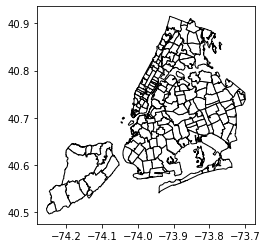

In [460]:
### Plot points on zip code map 
### zipcodes: https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u/data?no_mobile=true
# https://geopandas.org/gallery/create_geopandas_from_pandas.html
ax = zip_codes.plot(color='white', edgecolor='black')
# gdf_2017.plot(ax=ax, color='red')

<AxesSubplot:>

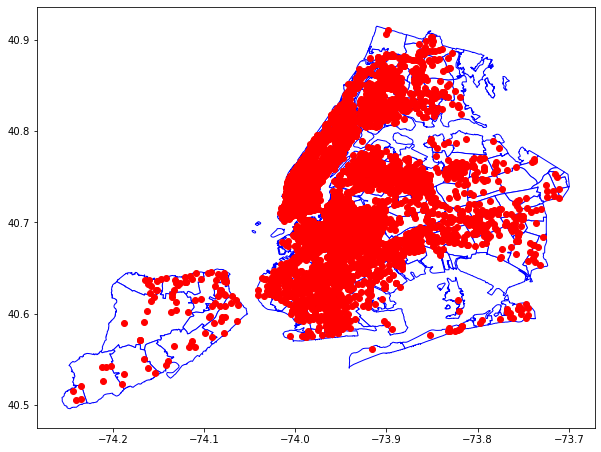

In [461]:
### 2017 Plot points on zip codes
ax = zip_codes.plot(color='white', edgecolor='blue', figsize= (10, 10))
gdf_2017.plot(ax=ax, color='red')

<AxesSubplot:>

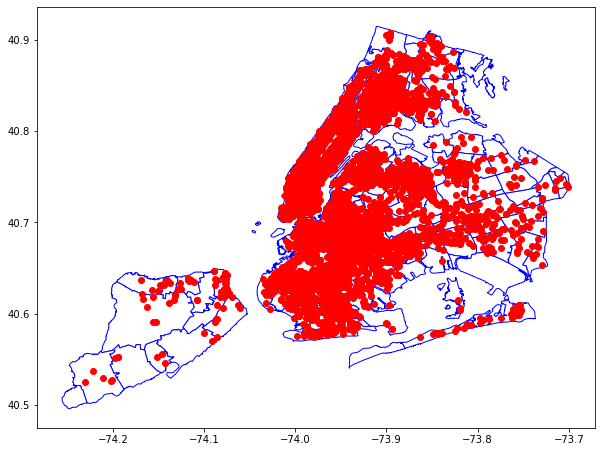

In [462]:
### 2018 Plot points on zip codes
ax = zip_codes.plot(color='white', edgecolor='blue', figsize= (10, 10))
gdf_2018.plot(ax=ax, color='red')

<AxesSubplot:>

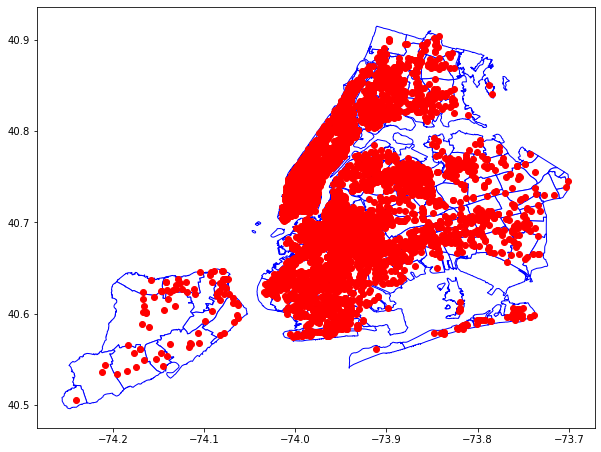

In [463]:
### 2019 Plot points on zip codes
ax = zip_codes.plot(color='white', edgecolor='blue', figsize= (10, 10))
gdf_2019.plot(ax=ax, color='red')

<AxesSubplot:>

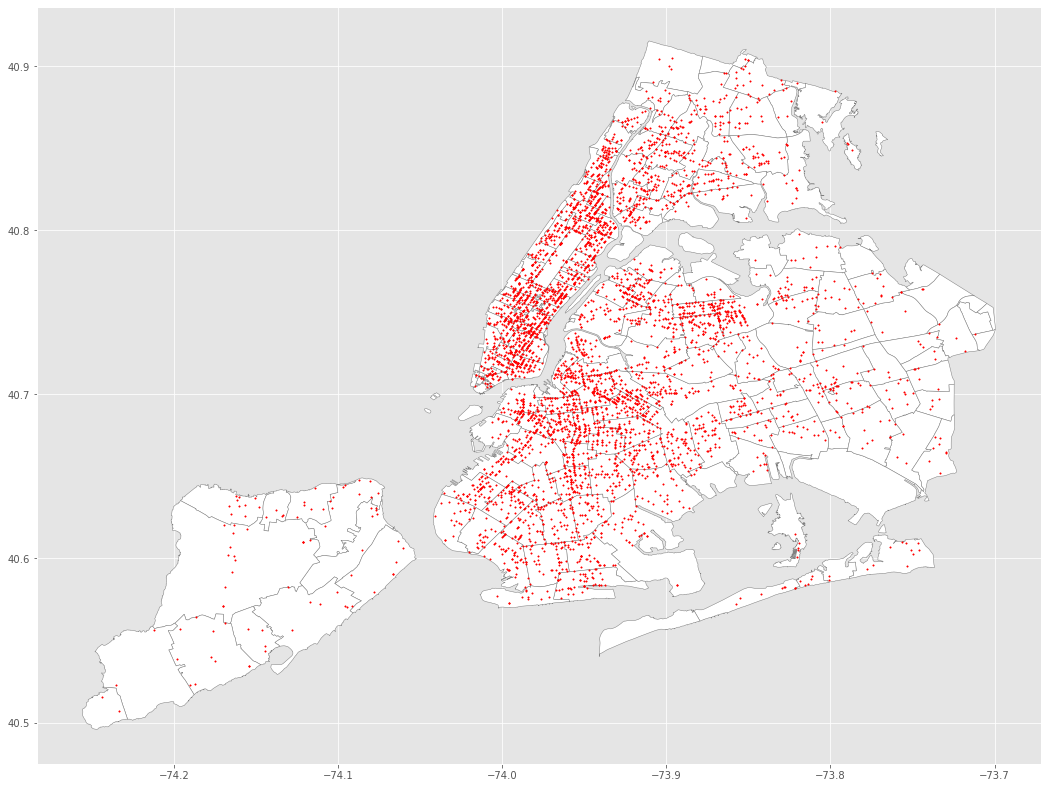

In [864]:
### 2020 Plot points on zip codes
ax = zip_codes.plot(color='white', edgecolor='gray', figsize= (18, 18))
gdf_2020.plot(ax=ax, color='red', markersize=2)

<AxesSubplot:>

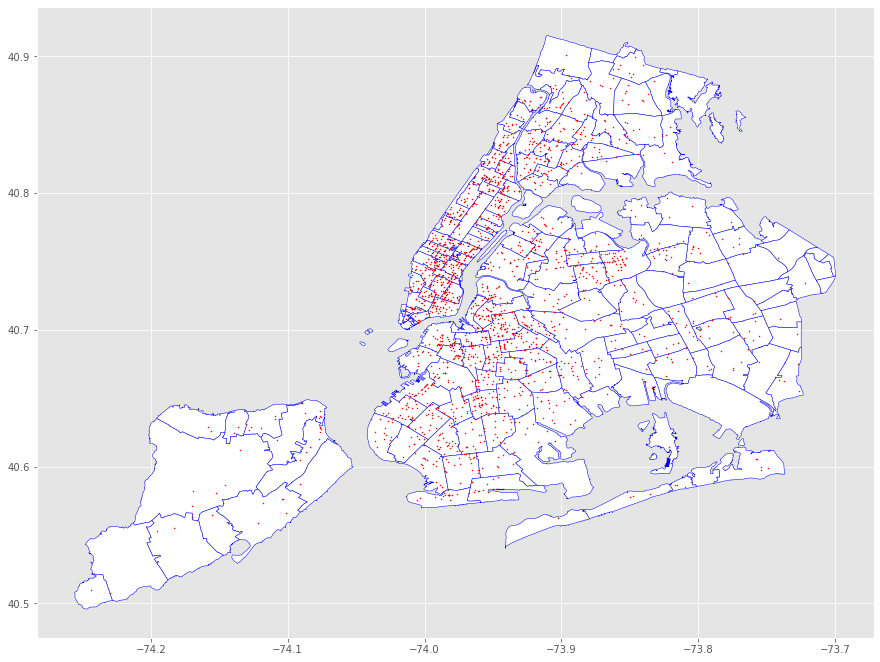

In [860]:
### 2021 Plot points on zip codes
ax = zip_codes.plot(color='white', edgecolor='blue', figsize= (15, 15))
gdf_2021.plot(ax=ax, color='red', markersize=1)

## Average accidents per zip code

# Bike lane data

<AxesSubplot:>

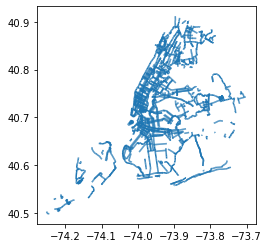

In [466]:
data_2018.plot()

<AxesSubplot:>

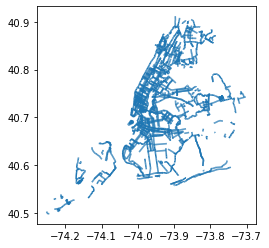

In [467]:
data_2019.plot()

<AxesSubplot:>

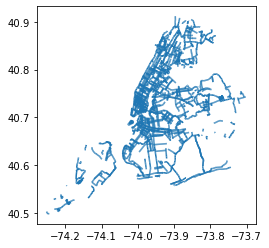

In [468]:
data_2020.plot()

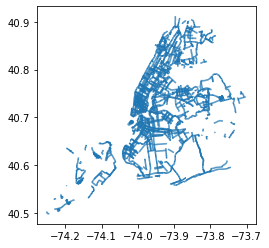

In [469]:
ax = data_2021.plot()
# gdf_2020.plot(ax=ax, color='red')

## Plot highest injury zipcodes

In [741]:
trash_list = ['10111', '10020', '10048']
zip_ranked_normalized_agg = zip_ranked_normalized_agg.reset_index()
zip_ranked_normalized_agg[~zip_ranked_normalized_agg['ZIPCODE'].isin(trash_list)]

zips_w_ranks = zip_codes.merge(zip_ranked_normalized_agg, right_on='ZIPCODE', left_on='ZIPCODE')
# zips_w_ranks.sort_values(by='Injuries by pop', ascending=False)
# zips_w_ranks
zips_w_ranks

ValueError: cannot insert level_0, already exists

In [746]:
zip_w_ranks['ZIPCODE' == '10111']

KeyError: False

/Users/julie/opt/anaconda3/envs/newenv/lib/python3.8/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


<AxesSubplot:>

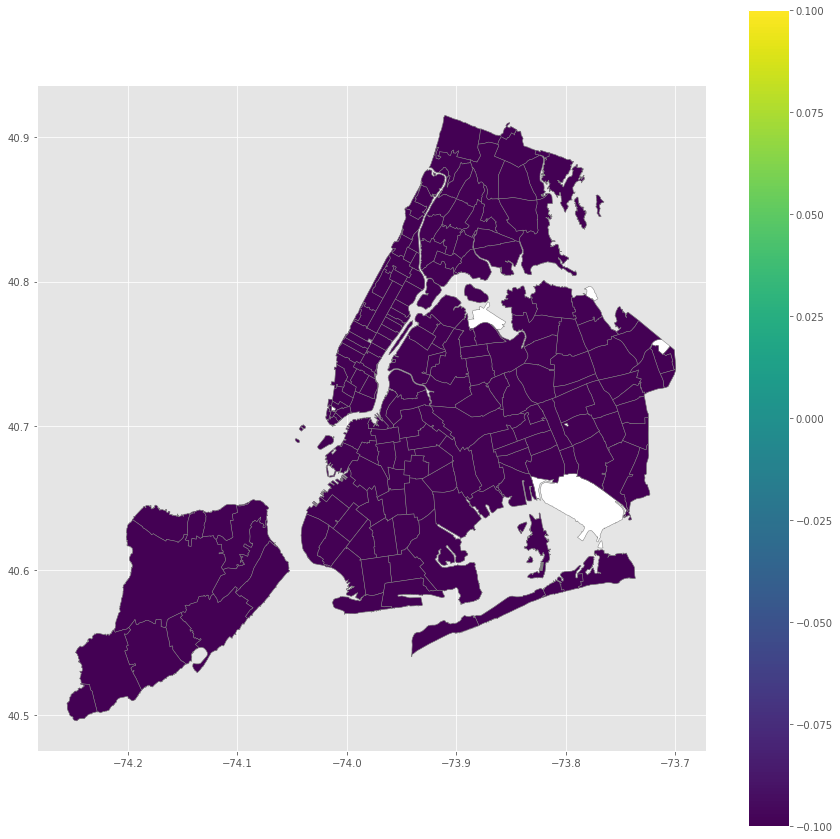

In [743]:
### 2017 Plot points on zip codes
trash_list = ['10111', '10020', '10048']
zip_ranked_normalized_agg = zip_ranked_normalized_agg.reset_index()
zip_ranked_normalized_agg[~zip_ranked_normalized_agg['ZIPCODE'].isin(trash_list)]
fig, ax = plt.subplots(figsize=(15,15))
zip_w_ranks = zip_codes.merge(zip_ranked_normalized_agg, right_on='ZIPCODE', left_on='ZIPCODE')
zip_outlines = zip_codes.plot(color='white', edgecolor='gray', figsize= (8, 8), ax=ax)

zip_w_ranks.plot(edgecolor='gray', column=zip_w_ranks['Injuries by pop'], ax=zip_outlines, legend=True)

# zips_w_ranks = zip_codes.merge(zip_ranked_normalized_agg, right_on='ZIPCODE', left_on='ZIPCODE')
# # gdf_2017.plot(ax=ax, color='red')
# zips_w_ranks = zip_codes.merge(zip_ranked_normalized_agg, right_on='ZIPCODE', left_on='ZIPCODE')
# near_evil_zips = nyc_zip_df_lat.merge(near_evil, right_on='start_zipcode' ,left_on='ZIPCODE')

# trash_list = ['10111', '10020', '10048']
# zip_ranked_normalized_agg = zip_ranked_normalized_agg.reset_index()
# zip_ranked_normalized_agg[~zip_ranked_normalized_agg['ZIPCODE'].isin(trash_list)]
# zip_ranked_normalized_agg



In [752]:
zip_ranked = zip_results[['ZIPCODE', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED','POPULATION']]
zip_ranked = zip_ranked.dropna()
zip_ranked = zip_ranked.groupby('ZIPCODE').agg("NUMBER OF CYCLIST ")

,ZIPCODE,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,POPULATION
53,11368,1,0,109069.0
91,11214,1,0,89061.0
128,11205,0,0,41125.0
140,10452,1,0,76104.0
146,11201,1,0,53041.0
...,...,...,...,...
1423549,10016,1,0,54606.0
1522962,10036,1,0,23543.0
1587016,11201,0,0,53041.0
1730144,10013,1,0,27985.0


In [871]:
zip_ranked = zip_results[['ZIPCODE', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED']]
zip_ranked = zip_ranked.dropna()    
zip_ranked = zip_ranked.rename(columns={'NUMBER OF CYCLIST INJURED':'Injuries', 'NUMBER OF CYCLIST KILLED':'Fatalities'})
zip_ranked = zip_ranked.groupby('ZIPCODE').agg({'Injuries':'sum', 'Fatalities':'sum'})
zip_ranked.sort_values(by='Fatalities', ascending=False)

,Injuries,Fatalities
ZIPCODE,,
11223,220,4
11211,437,4
11230,237,3
11101,336,3
11221,388,3
...,...,...
10459,119,0
10462,109,0
10463,71,0


In [753]:
zip_ranked = zip_results[['ZIPCODE', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED']]
zip_ranked = zip_ranked.dropna()    
zip_ranked = zip_ranked.rename(columns={'NUMBER OF CYCLIST INJURED':'Injuries', 'NUMBER OF CYCLIST KILLED':'Fatalities'})
zip_ranked = zip_ranked.groupby('ZIPCODE').agg({'Injuries':'sum', 'Fatalities':'sum'})
zip_ranked.sort_values(by='Injuries', ascending=False)

,Injuries,Fatalities
ZIPCODE,,
11206,574,2
11211,437,4
10002,423,1
10003,394,2
11368,392,0
...,...,...
10044,1,0
10069,1,0
10111,1,0


<AxesSubplot:>

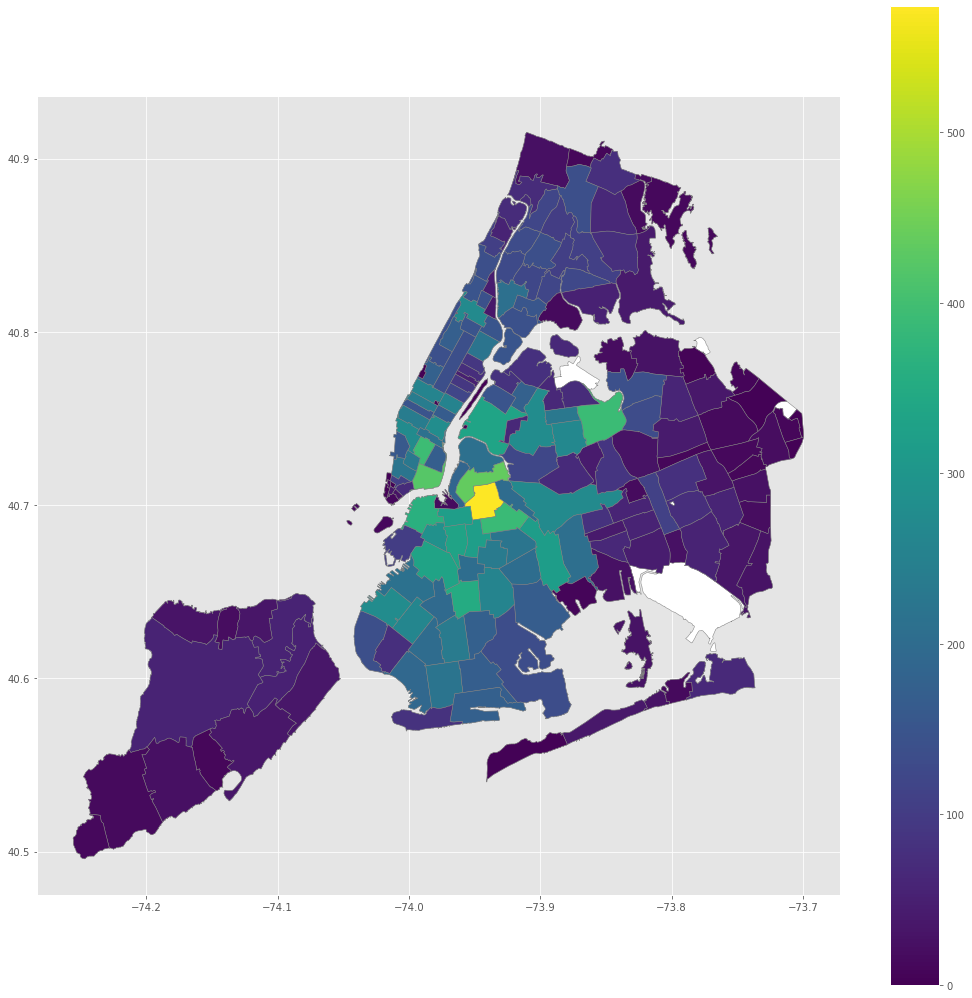

In [844]:
zip_ranked = zip_results[['ZIPCODE', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED']]
zip_ranked = zip_ranked.dropna()    
zip_ranked = zip_ranked.rename(columns={'NUMBER OF CYCLIST INJURED':'Injuries', 'NUMBER OF CYCLIST KILLED':'Fatalities'})
zip_ranked = zip_ranked.groupby('ZIPCODE').agg({'Injuries':'sum', 'Fatalities':'sum'})
zip_ranked.sort_values(by='Injuries', ascending=False)



fig, ax = plt.subplots(figsize=(18,18))
zip_w_ranks2 = zip_codes.merge(zip_ranked, right_on='ZIPCODE', left_on='ZIPCODE')
zip_outlines = zip_codes.plot(color='white', edgecolor='gray', ax=ax)

zip_w_ranks2.plot(edgecolor='gray', column=zip_w_ranks2['Injuries'], ax=zip_outlines, legend=True)

<AxesSubplot:>

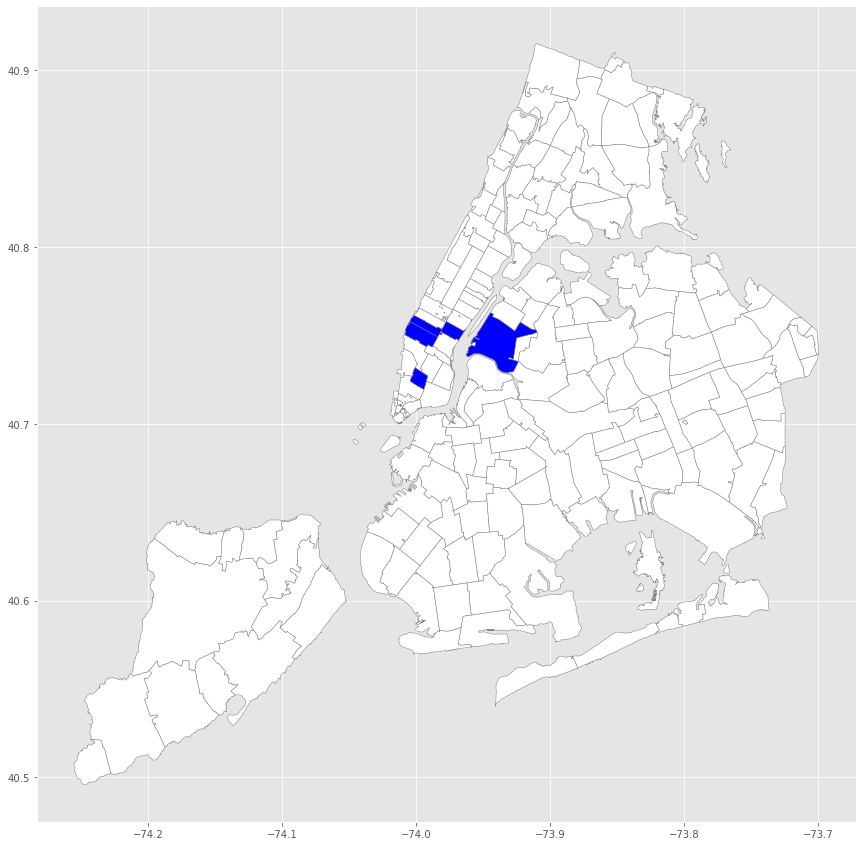

In [852]:
## Most dangerous zips normalized by population 
fig, ax = plt.subplots(figsize=(15,15))
zip_outlines = zip_codes.plot(color='white', edgecolor='gray', ax=ax)

danger_zip = zip_codes.merge(most_dangerous_zip, right_on='ZIPCODE', left_on='ZIPCODE')
danger_zip.iloc[0:5].plot(edgecolor='gray', color='blue', ax=zip_outlines, legend=True)



In [848]:
most_dangerous_zip.iloc[0:5]

,ZIPCODE,Injuries by pop,Fatalities by pop
135,11251,0.229730,0.000000
16,10018,0.027076,0.000000
7,10007,0.014885,0.000137
90,11101,0.012798,0.000114
6,10006,0.011292,0.000000


<AxesSubplot:>

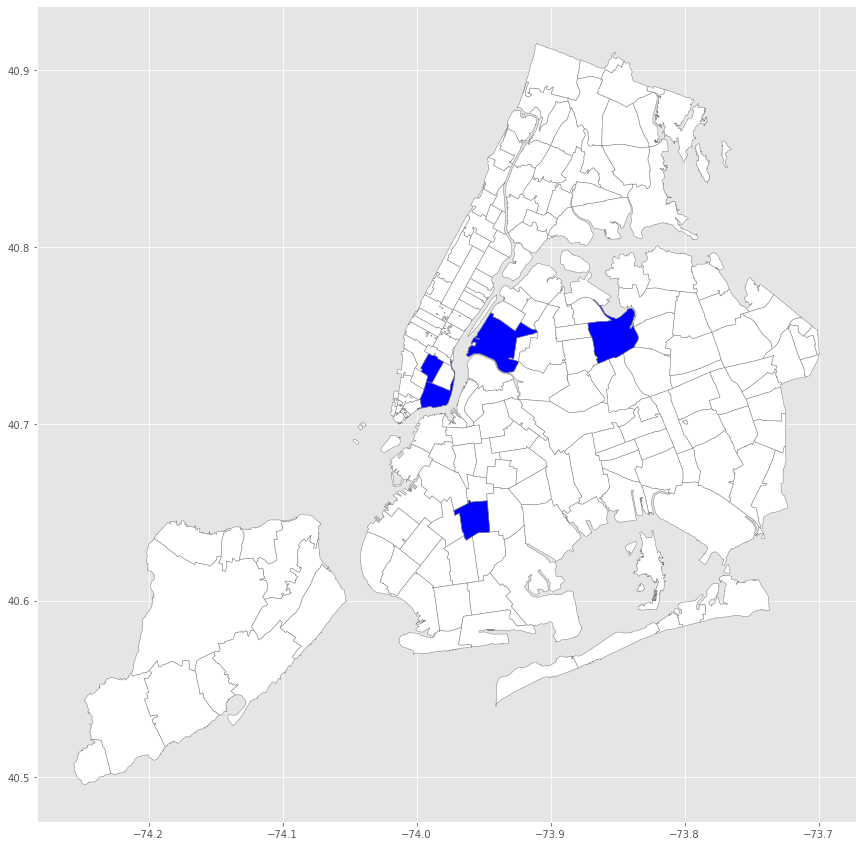

In [851]:
## Most dangerous zips NOT normalized by population 
fig, ax = plt.subplots(figsize=(15,15))
zip_outlines = zip_codes.plot(color='white', edgecolor='gray', ax=ax)

danger_zip2 = zip_codes.merge(most_dangerous_zip2, right_on='ZIPCODE', left_on='ZIPCODE')
danger_zip2.iloc[0:5].plot(edgecolor='gray', color='blue', ax=zip_outlines, legend=True)



<AxesSubplot:>

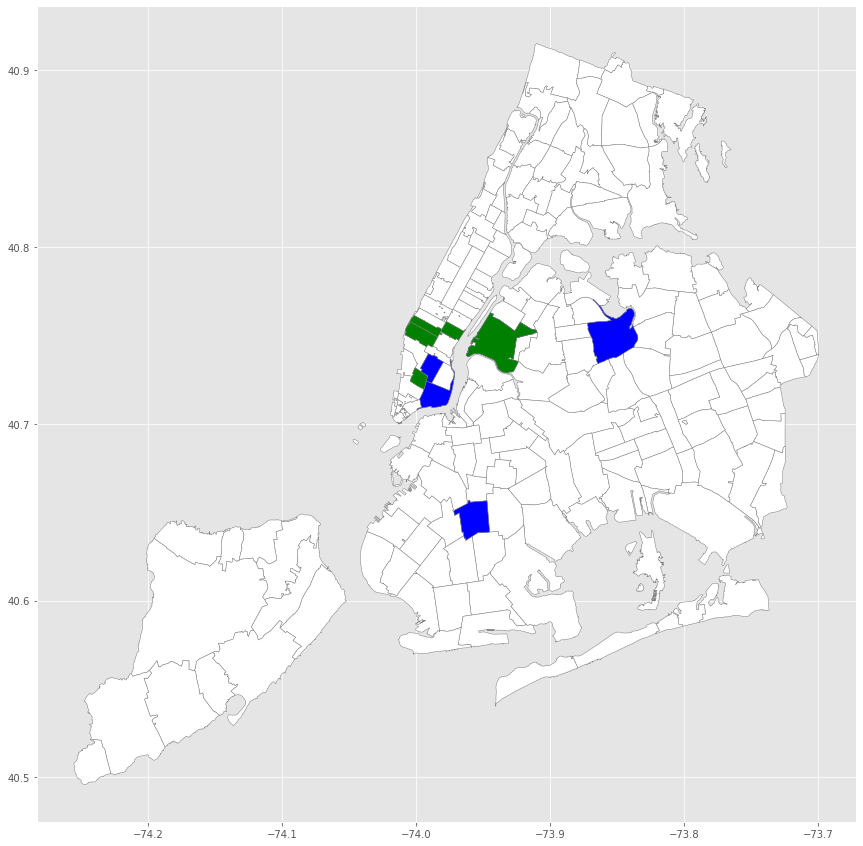

In [850]:
## Most dangerous combined
fig, ax = plt.subplots(figsize=(15,15))
zip_outlines = zip_codes.plot(color='white', edgecolor='gray', ax=ax)

danger_zip2 = zip_codes.merge(most_dangerous_zip2, right_on='ZIPCODE', left_on='ZIPCODE')
danger_zip2.iloc[0:5].plot(edgecolor='gray', color='blue', ax=zip_outlines, legend=True)
danger_zip.iloc[0:5].plot(edgecolor='gray', color='green', ax=zip_outlines, legend=True)

In [854]:
most_dangerous_zip2

,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED
ZIPCODE,,
11206,574,2
11211,437,4
10002,423,1
10003,394,2
11368,392,0
11221,388,3
11201,365,0
11226,352,2
11101,336,3
